In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('league_of_legends_data_large.csv')
X = data.drop('win', axis=1)
y = data['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [2]:
import torch.nn as nn
import torch.optim as optim
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [3]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)
train_preds = (y_pred_train > 0.5).float()
test_preds = (y_pred_test > 0.5).float()
train_acc = (train_preds == y_train_tensor).float().mean()
test_acc = (test_preds == y_test_tensor).float().mean()

print(f'Training Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Epoch [100/1000], Loss: 0.7061
Epoch [200/1000], Loss: 0.6983
Epoch [300/1000], Loss: 0.6933
Epoch [400/1000], Loss: 0.6902
Epoch [500/1000], Loss: 0.6883
Epoch [600/1000], Loss: 0.6871
Epoch [700/1000], Loss: 0.6864
Epoch [800/1000], Loss: 0.6860
Epoch [900/1000], Loss: 0.6857
Epoch [1000/1000], Loss: 0.6855
Training Accuracy: 0.5562
Test Accuracy: 0.5100


In [4]:
model = LogisticRegressionModel(input_dim)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)  # L2 regularization
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'[L2] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)
train_preds = (y_pred_train > 0.5).float()
test_preds = (y_pred_test > 0.5).float()
train_acc = (train_preds == y_train_tensor).float().mean()
test_acc = (test_preds == y_test_tensor).float().mean()

print(f'[L2] Training Accuracy: {train_acc:.4f}')
print(f'[L2] Test Accuracy: {test_acc:.4f}')

[L2] Epoch [100/1000], Loss: 0.7265
[L2] Epoch [200/1000], Loss: 0.7103
[L2] Epoch [300/1000], Loss: 0.7004
[L2] Epoch [400/1000], Loss: 0.6944
[L2] Epoch [500/1000], Loss: 0.6908
[L2] Epoch [600/1000], Loss: 0.6887
[L2] Epoch [700/1000], Loss: 0.6874
[L2] Epoch [800/1000], Loss: 0.6866
[L2] Epoch [900/1000], Loss: 0.6861
[L2] Epoch [1000/1000], Loss: 0.6858
[L2] Training Accuracy: 0.5412
[L2] Test Accuracy: 0.5100


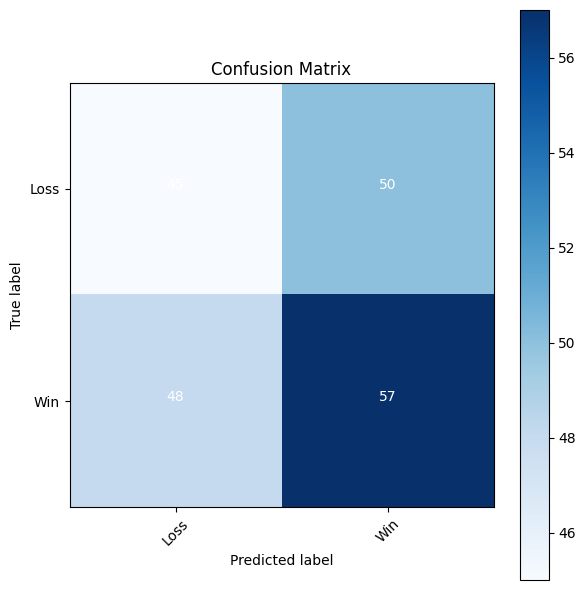

Classification Report:
               precision    recall  f1-score   support

        Loss       0.48      0.47      0.48        95
         Win       0.53      0.54      0.54       105

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200



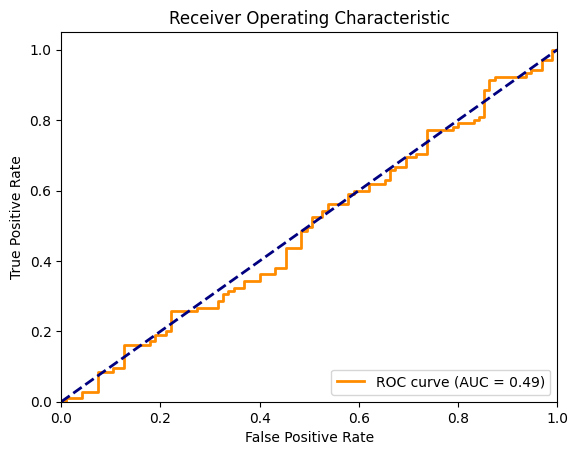

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Confusion matrix
y_pred_test_labels = test_preds
cm = confusion_matrix(y_test, y_pred_test_labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test_labels, target_names=['Loss', 'Win']))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
torch.save(model.state_dict(), 'logreg_model.pth')
print("Model saved successfully.")

# Load the model
loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load('logreg_model.pth'))
print("Model loaded successfully.")

# Ensure the loaded model is in evaluation mode
loaded_model.eval()

# Evaluate the loaded model
with torch.no_grad():
    y_pred_loaded = loaded_model(X_test_tensor)
    test_preds_loaded = (y_pred_loaded > 0.5).float()
    test_accuracy_loaded = (test_preds_loaded == y_test_tensor).float().mean()
    print(f"Loaded Model Test Accuracy: {test_accuracy_loaded:.4f}")

Model saved successfully.
Model loaded successfully.
Loaded Model Test Accuracy: 0.5100


In [7]:
learning_rates = [0.01, 0.05, 0.1]
epochs = 100
results = {}

for lr in learning_rates:
    # Reinitialize model and optimizer
    model = LogisticRegressionModel(input_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        preds = (y_pred > 0.5).float()
        accuracy = (preds == y_test_tensor).float().mean().item()
        results[lr] = accuracy
        print(f"Learning Rate: {lr}, Test Accuracy: {accuracy:.4f}")

# Report best
best_lr = max(results, key=results.get)
print(f"\nBest Learning Rate: {best_lr} with Accuracy: {results[best_lr]:.4f}")

Learning Rate: 0.01, Test Accuracy: 0.5100
Learning Rate: 0.05, Test Accuracy: 0.5000
Learning Rate: 0.1, Test Accuracy: 0.5250

Best Learning Rate: 0.1 with Accuracy: 0.5250


        Feature  Importance
3   gold_earned    0.181565
0         kills    0.137719
5  wards_placed    0.105470
6  wards_killed   -0.054909
7  damage_dealt   -0.034008
1        deaths   -0.033474
4            cs   -0.002583
2       assists   -0.000026


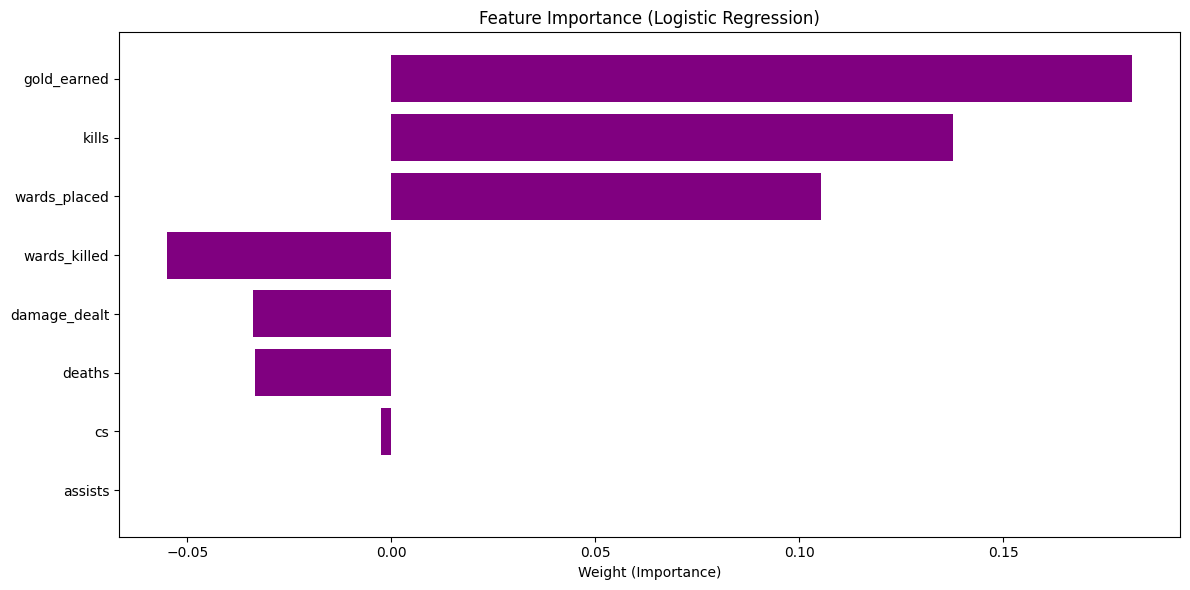

In [8]:
weights = model.linear.weight.data.numpy().flatten()
features = X.columns
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': weights
})
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)
print(feature_importance[['Feature', 'Importance']])
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='purple')
plt.xlabel('Weight (Importance)')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()